Since the backbone has been frozen in our approach, users can conveniently acquire the pre-trained weights from [facebookresearch](https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth). With these weights, users can effortlessly generate the complete model weights using `dinov2_rein_and_head.pth`.

In [1]:
! python tools/generate_full_weights.py --dinov2_segmentor_path checkpoints/dinov2_segmentor_acdc.pth --backbone checkpoints/dinov2_converted_1024x1024.pth --rein_head work_dirs/rein_dinov2_mask2former_512x512_bs1x4/iter_40000.pth

Original pos_embed shape: torch.Size([1, 65, 1024])


In [1]:
# import and init
import torch
import torch.nn as nn
import rein
from mmengine.config import Config
from mmseg.apis.inference import inference_model,show_result_pyplot,init_model
import matplotlib.pyplot as plt
cfg=Config.fromfile('configs/dinov2/rein_dinov2_mask2former_512x512_bs1x4.py')
network:nn.Module=init_model(cfg,'checkpoints/dinov2_segmentor_acdc.pth','cuda:0')
network.cfg=cfg
network.cfg.test_pipeline=network.cfg.cityscapes_test_pipeline
torch.set_grad_enabled(True)

/home/talmacsi/anaconda3/envs/rein/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
/home/talmacsi/Documents/BME/Onlab2/Rein/rein/models/backbones/dino_layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/talmacsi/Documents/BME/Onlab2/Rein/rein/models/backbones/dino_layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/talmacsi/Documents/BME/Onlab2/Rein/rein/models/backbones/dino_layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Loads checkpoint by local backend from path: checkpoints/dinov2_segmentor_acdc.pth


In [31]:
import os
import random
import glob

# Alapértelmezett elérési utak
rgb_anon_path = "data/acdc/rgb_anon"
gt_path = "data/acdc/gt"

def find_images_and_annotations():
    # Képek és szegmentációk elérési útvonalainak tárolása
    images = []
    annotations = []

    # Végigjárjuk a különböző időjárási körülményeket
    for condition in ['fog', 'rain', 'night']:
        # Elérési útvonalak a képekhez és szegmentációkhoz
        condition_rgb_path = os.path.join(rgb_anon_path, condition, 'train')
        condition_gt_path = os.path.join(gt_path, condition, 'train')

        # Bejárjuk az összes mappát a megadott elérési úton
        for folder in os.listdir(condition_rgb_path):
            folder_rgb_path = os.path.join(condition_rgb_path, folder)
            folder_gt_path = os.path.join(condition_gt_path, folder)

            # Képek és szegmentációk keresése
            if os.path.isdir(folder_rgb_path) and os.path.isdir(folder_gt_path):
                images.extend(glob.glob(os.path.join(folder_rgb_path, '*.png')))
                annotations.extend(glob.glob(os.path.join(folder_gt_path, '*gt_labelColor.png')))

    return images, annotations

def select_random_image_and_annotation(images, annotations):
    # Véletlenszerű kép kiválasztása
    random_image = random.choice(images)
    
    # Megfelelő szegmentációs fájl keresése
    base_name = os.path.basename(random_image).rsplit('.', 1)[0].split('_rgb_anon')[0]
    print(base_name)
    matching_annotations = [ann for ann in annotations if base_name in os.path.basename(ann)]

    if matching_annotations:
        random_annotation = random.choice(matching_annotations)
        return random_image, random_annotation
    else:
        return random_image, None

# Képek és szegmentációk keresése
images, annotations = find_images_and_annotations()

print(annotations)

# Véletlenszerű kép és szegmentáció kiválasztása
random_image, random_annotation = select_random_image_and_annotation(images, annotations)

print("Randomly selected image:", random_image)
print("Corresponding annotation:", random_annotation)


['data/acdc/gt/fog/train/GP020478/GP020478_frame_000317_gt_labelColor.png', 'data/acdc/gt/fog/train/GP020478/GP020478_frame_000095_gt_labelColor.png', 'data/acdc/gt/fog/train/GP020478/GP020478_frame_000134_gt_labelColor.png', 'data/acdc/gt/fog/train/GP020478/GP020478_frame_000329_gt_labelColor.png', 'data/acdc/gt/fog/train/GP020478/GP020478_frame_000062_gt_labelColor.png', 'data/acdc/gt/fog/train/GP020478/GP020478_frame_000107_gt_labelColor.png', 'data/acdc/gt/fog/train/GP020478/GP020478_frame_000197_gt_labelColor.png', 'data/acdc/gt/fog/train/GP020478/GP020478_frame_000201_gt_labelColor.png', 'data/acdc/gt/fog/train/GP020478/GP020478_frame_000054_gt_labelColor.png', 'data/acdc/gt/fog/train/GP020478/GP020478_frame_000146_gt_labelColor.png', 'data/acdc/gt/fog/train/GP020478/GP020478_frame_000326_gt_labelColor.png', 'data/acdc/gt/fog/train/GP020478/GP020478_frame_000099_gt_labelColor.png', 'data/acdc/gt/fog/train/GP020478/GP020478_frame_000050_gt_labelColor.png', 'data/acdc/gt/fog/train/

GP010376_frame_000036


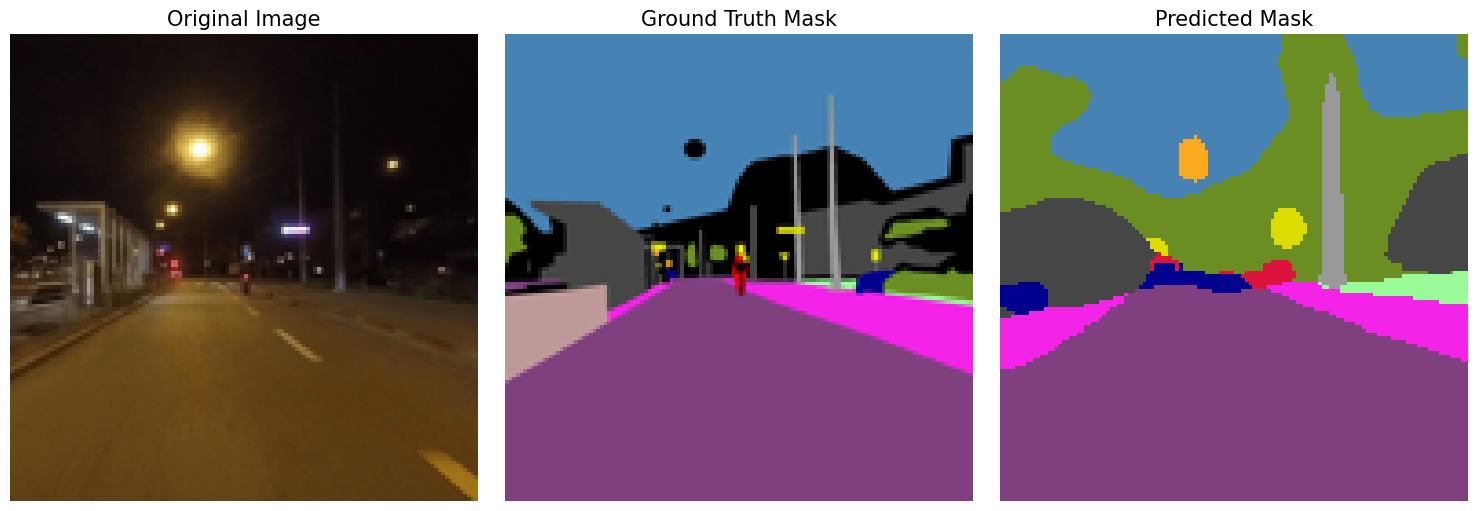

In [112]:
from PIL import Image
import numpy as np
from mmseg.apis.utils import _preprare_data
import numpy as np

random_image, random_annotation = select_random_image_and_annotation(images, annotations)

im_path = random_image
image = Image.open(im_path).convert("RGB")

image = image.resize((256, 128), resample=Image.Resampling.BICUBIC)
image = image.crop((64, 0, 192, 128))

image_array = np.array(image)
# Add random noise to the image
noisy_image = image_array + np.random.normal(loc=0, scale=10, size=image_array.shape)

# Clip the pixel values to the valid range (0-255)
noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

data, _ = _preprare_data(image_array, network)
data['inputs'][0] = data['inputs'][0].float() 
data['inputs'][0].requires_grad_(True)

# forward the model
results = network.test_step(data)

mask_color_path = random_annotation
mask_color = Image.open(mask_color_path)

mask_color = mask_color.resize((256, 128), resample=Image.Resampling.BICUBIC)
mask_color = mask_color.crop((64, 0, 192, 128))

mask_color = np.array(mask_color)

vis_img = show_result_pyplot(model=network, img=image_array, result=results[0], with_labels=False, opacity=1.0)

# Set up the figure size and layout
plt.figure(figsize=(15, 5))  # Adjust the figure size to fit three subplots comfortably

# Plotting the original image
plt.subplot(1, 3, 1)
plt.title("Original Image", fontsize=15)
plt.imshow(image_array)
plt.axis('off')

# Plotting the ground truth mask
plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask", fontsize=15)
plt.imshow(mask_color, cmap='viridis')  # Using a colormap for better visualization
plt.axis('off')

# Plotting the predicted mask
plt.subplot(1, 3, 3)
plt.title("Predicted Mask", fontsize=15)
plt.imshow(vis_img, cmap='plasma')  # Using a different colormap for distinction
plt.axis('off')

# Adjust layout to avoid overlap
plt.tight_layout()

plt.show()



(128, 128, 1)
tensor([ 0,  1,  2,  5,  7,  8,  9, 10, 11, 13], device='cuda:0')
mask: (128, 128, 1)


(-0.5, 127.5, 127.5, -0.5)

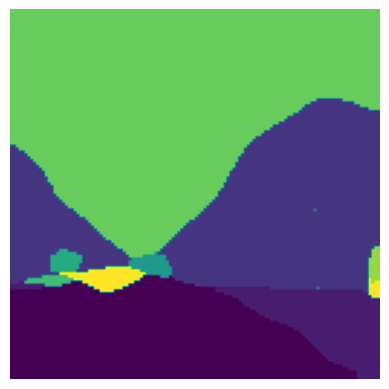

In [4]:
output = results[0].pred_sem_seg.data.permute(1,2,0).cpu().numpy() # shape 1, 128, 128
print(output.shape)
print(results[0].pred_sem_seg.data.unique())

# Create a mask of pixels that are equal to the target number
mask = output == 0
print("mask:", mask.shape)

plt.imshow(output)
plt.axis('off')

In [5]:
dataset_meta = dict(classes=network.dataset_meta['classes'], palette=network.dataset_meta['palette'])
print(dataset_meta['classes'])
print(dataset_meta['palette'])

('road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle')
[[128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156], [190, 153, 153], [153, 153, 153], [250, 170, 30], [220, 220, 0], [107, 142, 35], [152, 251, 152], [70, 130, 180], [220, 20, 60], [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100], [0, 80, 100], [0, 0, 230], [119, 11, 32]]


In [6]:
from tools.labels import labels
class_info = [label.name for label in labels if label.ignoreInEval is False]
color_info = [label.color for label in labels if label.ignoreInEval is False]
print(class_info)
print(color_info)

['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']
[(128, 64, 128), (244, 35, 232), (70, 70, 70), (102, 102, 156), (190, 153, 153), (153, 153, 153), (250, 170, 30), (220, 220, 0), (107, 142, 35), (152, 251, 152), (70, 130, 180), (220, 20, 60), (255, 0, 0), (0, 0, 142), (0, 0, 70), (0, 60, 100), (0, 80, 100), (0, 0, 230), (119, 11, 32)]


In [7]:
map_to_id = {}
inst_map_to_id = {}
i, j = 0, 0
for label in labels:
    if label.ignoreInEval is False:
        map_to_id[label.id] = i
        i += 1
        if label.hasInstances is True:
            inst_map_to_id[label.id] = j
            j += 1

id_to_map = {id: i for i, id in map_to_id.items()}
inst_id_to_map = {id: i for i, id in inst_map_to_id.items()}

In [8]:
map_to_id

{7: 0,
 8: 1,
 11: 2,
 12: 3,
 13: 4,
 17: 5,
 19: 6,
 20: 7,
 21: 8,
 22: 9,
 23: 10,
 24: 11,
 25: 12,
 26: 13,
 27: 14,
 28: 15,
 31: 16,
 32: 17,
 33: 18}

In [9]:
map_to_id.keys()

dict_keys([7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33])

mask: (128, 128)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 19]
(128, 128)


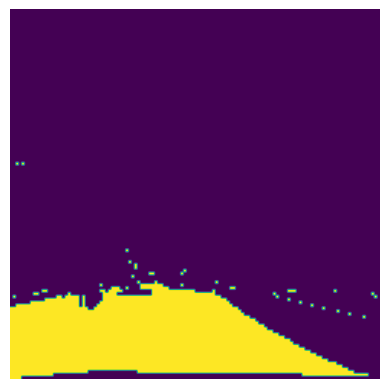

In [10]:

image = Image.open(mask_path)

image = image.resize((256, 128), resample=Image.Resampling.BICUBIC)
image = image.crop((64, 0, 192, 128))

image_array = np.array(image)
ignore_index = 19
# Map the pixel values using the dictionary
mapped_image_array = np.vectorize(map_to_id.get)(image_array, ignore_index)  # Use -1 for unmapped pixels

mask = mapped_image_array == 0
print("mask:", mask.shape)

print(np.unique(mapped_image_array))

print(mapped_image_array.shape)

plt.imshow(mask)
plt.axis('off')
plt.show()

In [11]:
import torch

def apply_class_mask(x_k, y, class_label):
    """
    Apply a class-specific mask to an image tensor to isolate regions of a specific class.
    
    Args:
    x_k (torch.Tensor): Input image tensor of shape [batch_size, channels, height, width].
    y (torch.Tensor): Label tensor of shape [batch_size, height, width] with class labels for each pixel.
    class_label (int): The class label for which to create the mask.
    
    Returns:
    torch.Tensor: The masked image tensor with the same shape as x_k.
    """
    # Create the binary mask for the specified class
    mask = (y == class_label).float().unsqueeze(1)  # Adding channel dimension to match x_k
    
    # Apply the mask element-wise
    x_k_masked = x_k * mask  # Broadcasting mask across channels
    
    return x_k_masked

# Example usage
batch_size, channels, height, width = 1, 3, 256, 256
x_k = torch.randn(batch_size, channels, height, width)  # Example input image tensor
y = torch.randint(0, 10, (batch_size, height, width))  # Example label tensor with 10 classes
class_label = 5  # We want to isolate regions belonging to class 5

x_k_masked = apply_class_mask(x_k, y, class_label)
print(x_k_masked.shape)  # Should be [1, 3, 256, 256]


torch.Size([1, 3, 256, 256])


True


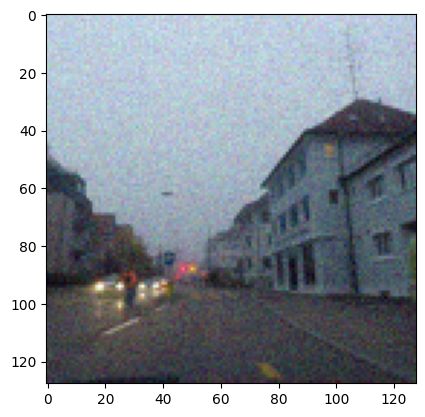

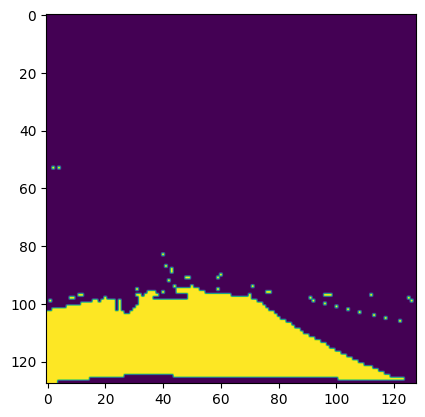

mc:  tensor([0, 1])
True


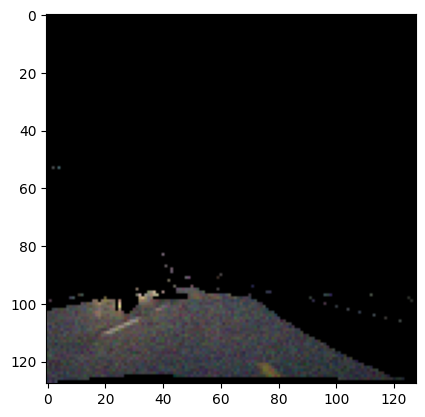

tensor([  0.,   8.,  19.,  22.,  24.,  25.,  26.,  28.,  29.,  31.,  32.,  33.,
         34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
         46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
         58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,
         70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,
         82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
         94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
        106., 107., 108., 109., 110., 111., 112., 113., 114., 115., 116., 117.,
        118., 119., 120., 121., 122., 123., 124., 125., 126., 127., 128., 129.,
        130., 131., 132., 133., 134., 135., 136., 137., 138., 139., 140., 141.,
        142., 143., 144., 145., 146., 147., 148., 149., 150., 152., 153., 154.,
        155., 160., 162., 163., 164., 165., 171., 173., 175., 177., 178., 179.,
        183., 191., 201., 204., 205., 22

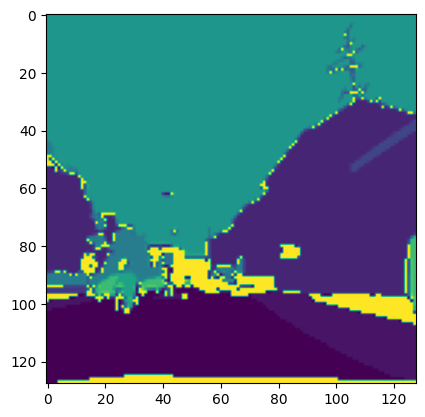

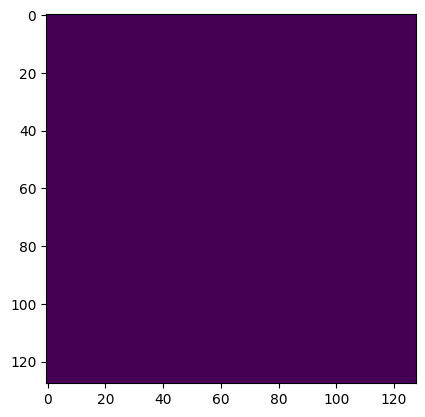

tensor([0])


In [12]:
x_k = torch.tensor(noisy_image).permute(2, 0, 1).unsqueeze(0).float() # [1,3,128,128]
y = torch.tensor(mapped_image_array).unsqueeze(0).long() # [1,128,128]
class_label = 0

mc = (y == class_label).long().unsqueeze(1) # [1,1,128,128]

x_k_masked = x_k * mc # [1,3,128,128]

# if class_label == 0:
#     y_c = torch.logical_not(mc) # [1, 1,128,128]
# else:
y_c = y * mc

print(19 in y.unique())

plt.imshow(x_k.squeeze(0).permute(1,2,0).numpy().astype(np.uint8))
plt.show()

plt.imshow(mc.squeeze(0).permute(1,2,0))
plt.show()
print("mc: ", mc.unique())
print(len(mc.unique()) != 1)
plt.imshow(x_k_masked.squeeze(0).permute(1,2,0).numpy().astype(np.uint8))
plt.show()
print(x_k_masked.unique())
print(x_k_masked.shape)

plt.imshow(y.permute(1,2,0))
plt.show()

plt.imshow(y_c.squeeze(0).permute(1,2,0))
plt.show()
print(y_c.unique())

In [13]:
x_k_masked = x_k_masked.squeeze(0).permute(1,2,0).numpy().astype(np.uint8)
data, _ = _preprare_data(x_k_masked, network)
data['inputs'][0] = data['inputs'][0].float() 
data['inputs'][0].requires_grad_(True)

#print(data)

# forward the model
results = network.test_step(data)

(128, 128, 1)
tensor([ 0,  2,  8, 13], device='cuda:0')


(-0.5, 127.5, 127.5, -0.5)

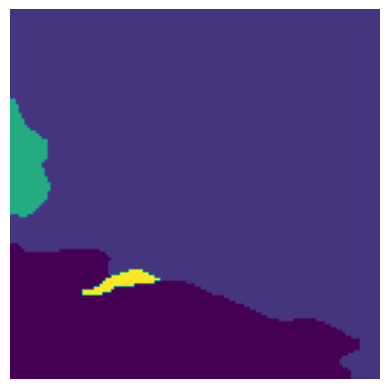

In [14]:
output = results[0].pred_sem_seg.data.permute(1,2,0).cpu().numpy() # shape 1, 128, 128
print(output.shape)
print(results[0].pred_sem_seg.data.unique())

masked_output = output * mc.squeeze(0).permute(1,2,0).numpy()

plt.imshow(output)
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

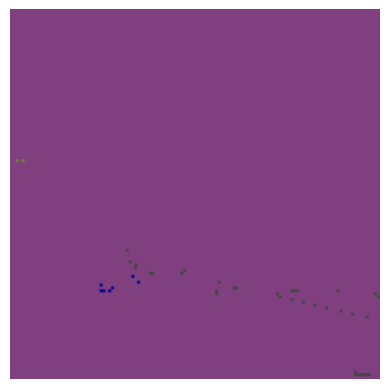

In [15]:
results[0].pred_sem_seg.data = torch.tensor(masked_output).permute(2,0,1)

vis_img = show_result_pyplot(model=network, img=noisy_image, result=results[0], with_labels=False, opacity=1.0)
plt.imshow(vis_img)
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


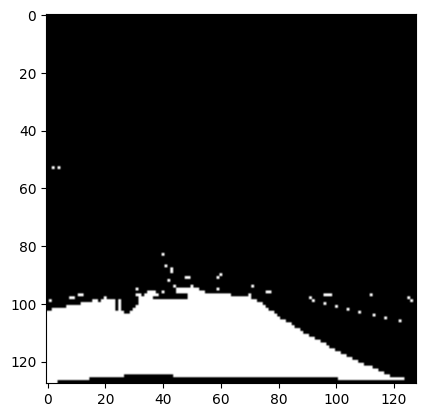

In [16]:
asd = data["inputs"][0].detach().permute(1,2,0).numpy().astype(np.float32)
plt.imshow(asd)

In [17]:
logits = results[0].seg_logits.data.unsqueeze(0).cpu() # (1, 19, 128, 128)
#masked_logits = logits * mc.unsqueeze(1).cpu() # (1, 19, 128, 128)
import torch.nn.functional as F
loss = F.cross_entropy(logits, y_c.squeeze(0).long(), ignore_index=1)
print("Cross-entropy Loss:", loss.item())

Cross-entropy Loss: 2.8672163486480713


In [18]:
(loss * mc).mean()

tensor(0.4569, grad_fn=<MeanBackward0>)